# Creating a Dataset from Google Images

### Search and Scroll through the gooogle images page.

We have to search google with the data that we are planning to train out models accordingly. The more specific we are in our search the more accurate we will get and hence we don't have to do much manual deleation throgh the data.After scrolling we have to scroll down till we reach the the number of data samples we require.

### Download the file

We must now download the links of these images into a file for this we can simply excecute a javascript command in the console of out browser. Press _ctrl+shift+j in Windows/Linux or Press _Cmd+Opt+J in Mac and paste the following code



``` javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```





## Creating directory and upload file into google labs

Now that we are using colabs and google drive we need to mount the drives and fetch the files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *

In [0]:
path_1 = Path("/content/drive/My Drive/Colab Notebooks/CSV")

In [0]:
folder = 'lamborghini'
file = 'urls_lamborghini_aventador.csv'

In [0]:
folder = 'ferrari'
file = 'urls_ferrari_laferrari.csv'

In [0]:
folder = 'mclaren'
file = 'urls_mclarensenna.csv'

In [0]:
path = Path('/content/data/cars')
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)

## Download Images


In [0]:
classes = ['lamborghini','ferrari','mclaren']

In [0]:
download_images(path_1/file,dest,max_pics=200)

Now we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c,delete=True,max_size=500)

# View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [17]:
data.classes

['ferrari', 'lamborghini', 'mclaren']

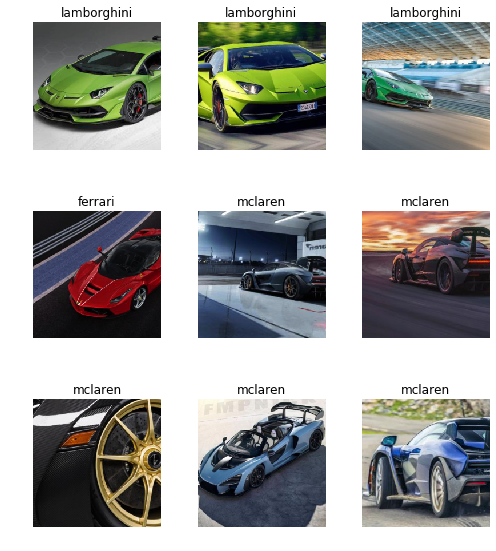

In [18]:
data.show_batch(rows=3, figsize=(7,8))

In [19]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['ferrari', 'lamborghini', 'mclaren'], 3, 446, 111)

#Training the model


In [20]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 118MB/s]


In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.845028,1.879245,0.486486,00:10
1,1.280384,0.608991,0.207207,00:08
2,0.973851,0.457298,0.153153,00:08
3,0.801093,0.472880,0.171171,00:08


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


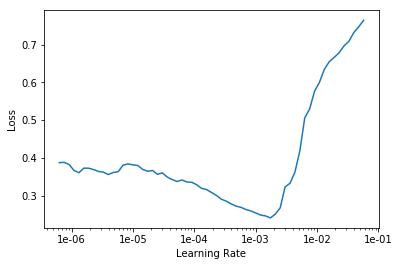

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.402984,0.393876,0.135135,00:09
1,0.322442,0.351157,0.126126,00:08


In [0]:
learn.save('stage-2')

# Interpretation


In [28]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (446 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
lamborghini,lamborghini,lamborghini,lamborghini,lamborghini
Path: /content/data/cars;

Valid: LabelList (111 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
lamborghini,ferrari,lamborghini,mclaren,lamborghini
Path: /content/data/cars;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

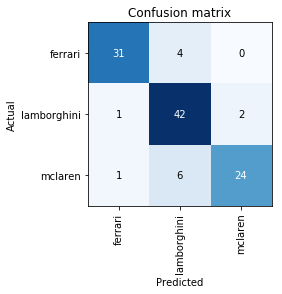

In [30]:
interp.plot_confusion_matrix()

# Cleaning Up

fastai.widget has ImageCleaning widget which can be used for clearning the unwanted images in our dataset. We are currently getting lots of error not because our model is bad but the data that is used in training this is contains images that are not suppose to be there.

In [0]:
from fastai.widgets import *

Now we need to get the files paths from out top_losses we can do this using the .from_toplosses. We have to then feed the index of these dataset to the ImageCleaner. The image cleaner will not directly delete this data from the disk but this will create a new csv file which contains the corrected DataBunch with the corrected labels to train our model.


In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Now we need to create a new learner to use our databunch with all the images

In [0]:
learn_cln = cnn_learner(db,models.resnet34,metrics=error_rate)
learn_cln.load('stage-2');

In [0]:
ds,idxs = DatasetFormatter().from_toplosses(learn_cln)

Its time to clean some text

In [38]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


#Putting model in production

First we have to export the content of our Learner object for procution

In [0]:
learn.export()

Exporting the model will create an export.pkl file which will contains everything that is required to deploy the model. The mode the weights and some metadata like classes ir the transforms/normalization used.

We can use a CPU for inference as we are using this on a low scale.

In [0]:
defaults.device = torch.device('cpu')

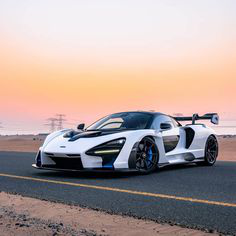

In [50]:
img = open_image(path_1/'senna.jpg')
img

In [0]:
learn = load_learner(path)

In [52]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category mclaren

In [53]:
img = open_image(path_1/'lambo.jpg')
img
learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category lamborghini